#Transfer learning with tensorflow part 3: Scaling up

We've seen transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101

Our goal is to beat the original food101 paper by using transfer learning

[Original Food101 Paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-03 08:38:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-03 08:38:35 (94.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import walk_through_dir,unzip_data,create_tensorboard_callback,plot_loss_curves,compare_historys

## 101 Food classes: working with less data

Our goal is to beat the original Food1010 paper with 10% of the traning data, so let's download it.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-08-03 08:38:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  99.2MB/s    in 15s     

2022-08-03 08:38:53 (102 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('101_food_classes_10_percent.zip')

In [ ]:
train_dir='101_food_classes_10_percent/train'
test_dir='101_food_classes_10_percent/test'

In [ ]:
#How many images/classes are in the dataset
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images i

In [ ]:
import tensorflow as tf

In [ ]:
#setup data inputs
IMG_SIZE=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE,
                                                              shuffle=False)
# Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Becoming one with data: Check images from the directories

In [ ]:
import matplotlib.pyplot as plt
import os
import random
import math
def plot_random_images(train_data_dir,class_names,no_of_images=2):
  plt.figure(figsize=(10,10))
  rows=math.ceil(no_of_images/2)
  cols=3
  for i in range(1,no_of_images+1):
    food_class=random.choice(class_names)
    target_dir=train_data_dir+'/'+food_class
    image_choice=random.choice(os.listdir(target_dir))
    image=target_dir+'/'+image_choice
    img=plt.imread(image)
    plt.subplot(rows,cols,i)
    plt.imshow(img)
    plt.title(food_class)
    plt.axis(False)
    

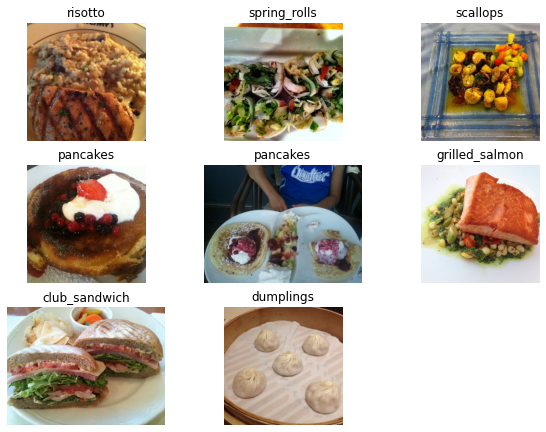

In [ ]:
plot_random_images(train_data_dir='101_food_classes_10_percent/train',
                   class_names=train_data_10_percent.class_names,
                   no_of_images=8)


## Train a big model with transfer learning on 10% of 101 food classes

Steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model(our own output layer)
* Compile our model
* Feature extract for 5 full passes( 5 epochs on train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path='101_food_classes_10_percent_data_model_checkpoint'
checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              save_weights_only=True,
                                              monitor='val_accuracy',
                                              save_best_only=True)

In [ ]:
#create a data augmentation layers to incorporate it right into the model
data_augmentation=tf.keras.Sequential([
          tf.keras.layers.RandomFlip('horizontal'),
          tf.keras.layers.RandomRotation(0.2),
          tf.keras.layers.RandomZoom(0.2),
          tf.keras.layers.RandomHeight(0.2),
          tf.keras.layers.RandomWidth(0.2)
          #tf.keras.layers.Rescaling(1/255.) if mode needs scaled data Req for 
          #models like resnet
],name='data_augmentation')

In [ ]:
#Setup a basemodel and freeze it's layers
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#create input layer
inputs=tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

#add augmentation layer
x=data_augmentation(inputs)

#add to base model
x=base_model(x,training=False)

# Create a pooling layer
x=tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)

# Create output layer
outputs=tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)

#Create a model

model0=tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model0.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
initial_epochs=5
history0=model0.fit(train_data_10_percent,
           epochs=initial_epochs,
           validation_data=test_data,
           validation_steps=int(0.15*len(test_data)),
           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                  experiment_name='10_percent_feature'),
                      checkpoint])

Saving TensorBoard log files to: transfer_learning/10_percent_feature/20220803-083922
Epoch 1/5
237/237 [==============================] - 95s 325ms/step - loss: 3.4814 - accuracy: 0.2430 - val_loss: 2.6752 - val_accuracy: 0.4049
Epoch 2/5
237/237 [==============================] - 63s 263ms/step - loss: 2.3449 - accuracy: 0.4626 - val_loss: 2.2350 - val_accuracy: 0.4672
Epoch 3/5
 10/237 [>.............................] - ETA: 44s - loss: 1.9807 - accuracy: 0.5375

KeyboardInterrupt: ignored

In [ ]:
model0.evaluate(test_data)

In [ ]:
plot_loss_curves(history0)

The loss curves suggest that the model is starting to overfit because the validation loss/accuracy corve is getting seperated from the training loss curve.

## Fine-tuning

In [ ]:
#unfreeze the layers of base model
base_model.trainable=True

#refreeze every layer except last 5 layers

for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
## Compiling the model again after the change
## keeping the learning rate lower
model0.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(lr=0.0001),
               metrics=['accuracy'])

In [ ]:
#checking trainable layers
for layer in model0.layers[2].layers:
  print(layer.name,layer.trainable)

In [ ]:

fine_tune_epochs=initial_epochs+5
history1=model0.fit(train_data_10_percent,
           epochs=fine_tune_epochs,
           validation_data=test_data,
           validation_steps=int(0.15*len(test_data)),
           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                  experiment_name='10_percent_fine')],
            initial_epoch=history0.epoch[-1])

In [ ]:
model0.evaluate(test_data)

## Fine tuning on 10 layers

In [ ]:
# reload model weights
model0.load_weights(checkpoint_path)

In [ ]:
#confirm loaded weights
model0.evaluate(test_data)

We've confirmed that the old weights have been reloaded. Let's unfreeze 10 layers this time

In [ ]:
#unfreeze the layers of base model
base_model.trainable=True

#refreeze every layer except last 10 layers

for layer in base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
## Compiling the model again after the change
## keeping the learning rate lower
model0.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(lr=0.0001),
               metrics=['accuracy'])

In [ ]:
#checking trainable layers
for layer in model0.layers[2].layers:
  print(layer.name,layer.trainable)

In [ ]:
fine_tune_epochs=initial_epochs+5
history2=model0.fit(train_data_10_percent,
           epochs=fine_tune_epochs,
           validation_data=test_data,
           validation_steps=int(0.15*len(test_data)),
           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                  experiment_name='10_percent_fine_10_layers')],
            initial_epoch=history0.epoch[-1])

In [ ]:
model0.evaluate(test_data)

In [ ]:
compare_historys(history0,history1,5)

In [ ]:
# for model with 10 unfrozen layers
compare_historys(history0,history2,5)

Unfreezing 10 layers didn't improve our model but worsned it a little. So, it didnt help much. 5 layers were enough.

We will use the whole dataset in the next module so enough experiments for now. Let's just use the last model because we didnt save the model after 5 layers.

## Saving and loading our model

to use a model in external application. we'll need to save it and explort it somewhere.

In [ ]:
model0.save('savedModel/101_food_class_10_percent_saved')

In [ ]:
# load and evaluate model
loaded_model=tf.keras.models.load_model('savedModel/101_food_class_10_percent_saved')

In [ ]:
loaded_model.evaluate(test_data)

So, the results of saved model matches with our loaded model.

## Evaluating the performance of the big model across the classes

Let's make some predictions,visualize them and then later find out which predictions were **most wrong**

Using the same model as video to check for prediction

In [ ]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-08-03 08:43:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   203MB/s    in 0.2s    

2022-08-03 08:43:36 (203 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
#load saved model

model=tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
#Evaluate loaded model

model.evaluate(test_data)

790/790 [==============================] - 67s 82ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

  ## Making predictions with our trained model

In [ ]:
#make predictions with model
pred_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 64s 79ms/step


In [ ]:
len(pred_probs)

25250

In [ ]:
len(pred_probs),101

(25250, 101)

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
#Let's see the first 10 predictions look life
pred_probs[:10]

array([[5.9541952e-02, 3.5742082e-06, 4.1376974e-02, ..., 1.4138680e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780576e-04, ..., 5.4286946e-05,
        7.8362811e-12, 9.8466213e-10],
       [9.5925879e-01, 3.2533622e-05, 1.4866935e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275776e-05],
       ...,
       [4.7313267e-01, 1.2931186e-07, 1.4805621e-03, ..., 5.9750048e-04,
        6.6968976e-05, 2.3469211e-05],
       [4.4571947e-02, 4.7265419e-07, 1.2258486e-01, ..., 6.3498483e-06,
        7.5318626e-06, 3.6778681e-03],
       [7.2438961e-01, 1.9249808e-09, 5.2310945e-05, ..., 1.2291385e-03,
        1.5792746e-09, 9.6395852e-05]], dtype=float32)

In [ ]:
#Let's see the first predictions look life
pred_probs[:1],sum(pred_probs[0])
# Prediction probabilities should add up to be 1

(array([[5.95419519e-02, 3.57420822e-06, 4.13769744e-02, 1.06605547e-09,
         8.16142798e-09, 8.66396554e-09, 8.09271114e-07, 8.56526640e-07,
         1.98590151e-05, 8.09776168e-07, 3.17277427e-09, 9.86738314e-07,
         2.85322167e-04, 7.80493392e-10, 7.42300879e-04, 3.89163397e-05,
         6.47404340e-06, 2.49773279e-06, 3.78911318e-05, 2.06783056e-07,
         1.55384496e-05, 8.15069370e-07, 2.62305412e-06, 2.00106655e-07,
         8.38272967e-07, 5.42159842e-06, 3.73909279e-06, 1.31505820e-08,
         2.77614314e-03, 2.80519198e-05, 6.85624113e-10, 2.55748309e-05,
         1.66888960e-04, 7.64069974e-10, 4.04528371e-04, 1.31506335e-08,
         1.79573772e-06, 1.44482158e-06, 2.30628997e-02, 8.24667779e-07,
         8.53657696e-07, 1.71386114e-06, 7.05252342e-06, 1.84021669e-08,
         2.85532963e-07, 7.94833795e-06, 2.06815525e-06, 1.85251338e-07,
         3.36196422e-08, 3.15225538e-04, 1.04109122e-05, 8.54483574e-07,
         8.47418606e-01, 1.05554345e-05, 4.40945854

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"what prediction probability sample 0 looks life:\n {pred_probs[0]}")
print(f"The class with the highest probability by the model for sample 0: {tf.argmax(pred_probs[0])}")

Number of prediction probabilities for sample 0: 101
what prediction probability sample 0 looks life:
 [5.95419519e-02 3.57420822e-06 4.13769744e-02 1.06605547e-09
 8.16142798e-09 8.66396554e-09 8.09271114e-07 8.56526640e-07
 1.98590151e-05 8.09776168e-07 3.17277427e-09 9.86738314e-07
 2.85322167e-04 7.80493392e-10 7.42300879e-04 3.89163397e-05
 6.47404340e-06 2.49773279e-06 3.78911318e-05 2.06783056e-07
 1.55384496e-05 8.15069370e-07 2.62305412e-06 2.00106655e-07
 8.38272967e-07 5.42159842e-06 3.73909279e-06 1.31505820e-08
 2.77614314e-03 2.80519198e-05 6.85624113e-10 2.55748309e-05
 1.66888960e-04 7.64069974e-10 4.04528371e-04 1.31506335e-08
 1.79573772e-06 1.44482158e-06 2.30628997e-02 8.24667779e-07
 8.53657696e-07 1.71386114e-06 7.05252342e-06 1.84021669e-08
 2.85532963e-07 7.94833795e-06 2.06815525e-06 1.85251338e-07
 3.36196422e-08 3.15225538e-04 1.04109122e-05 8.54483574e-07
 8.47418606e-01 1.05554345e-05 4.40945854e-07 3.74041447e-05
 3.53061914e-05 3.24890389e-05 6.73146787e-

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes=pred_probs.argmax(axis=1)

pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

Since our test_data is in batch format we need to unravel it to get the labels from the test_data and use it to evaluate our model.

Since the test labels are one hot encoded so we will need to use argmax to get the index values so thats why we are using argmax

In [ ]:
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Why there are all 0s in the start? because we loaded our data class by class so its 0 then 1 and goes on. We set shuffle=False so whenever we load our data it's not shuffled and we can make preidictions from it

## Evaluate our model predictions

One way to check that our model's predictions array is in the same order as our test labels, we can check the accuracy score

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_labels,pred_classes)

0.6077623762376237

so the labels are alright because the accuracy score is some as the accuracy above

## Let's get visual: making confusion matrix

In [ ]:
# We need to make changes to our confusion matriximport itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #changed (plot x label vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)

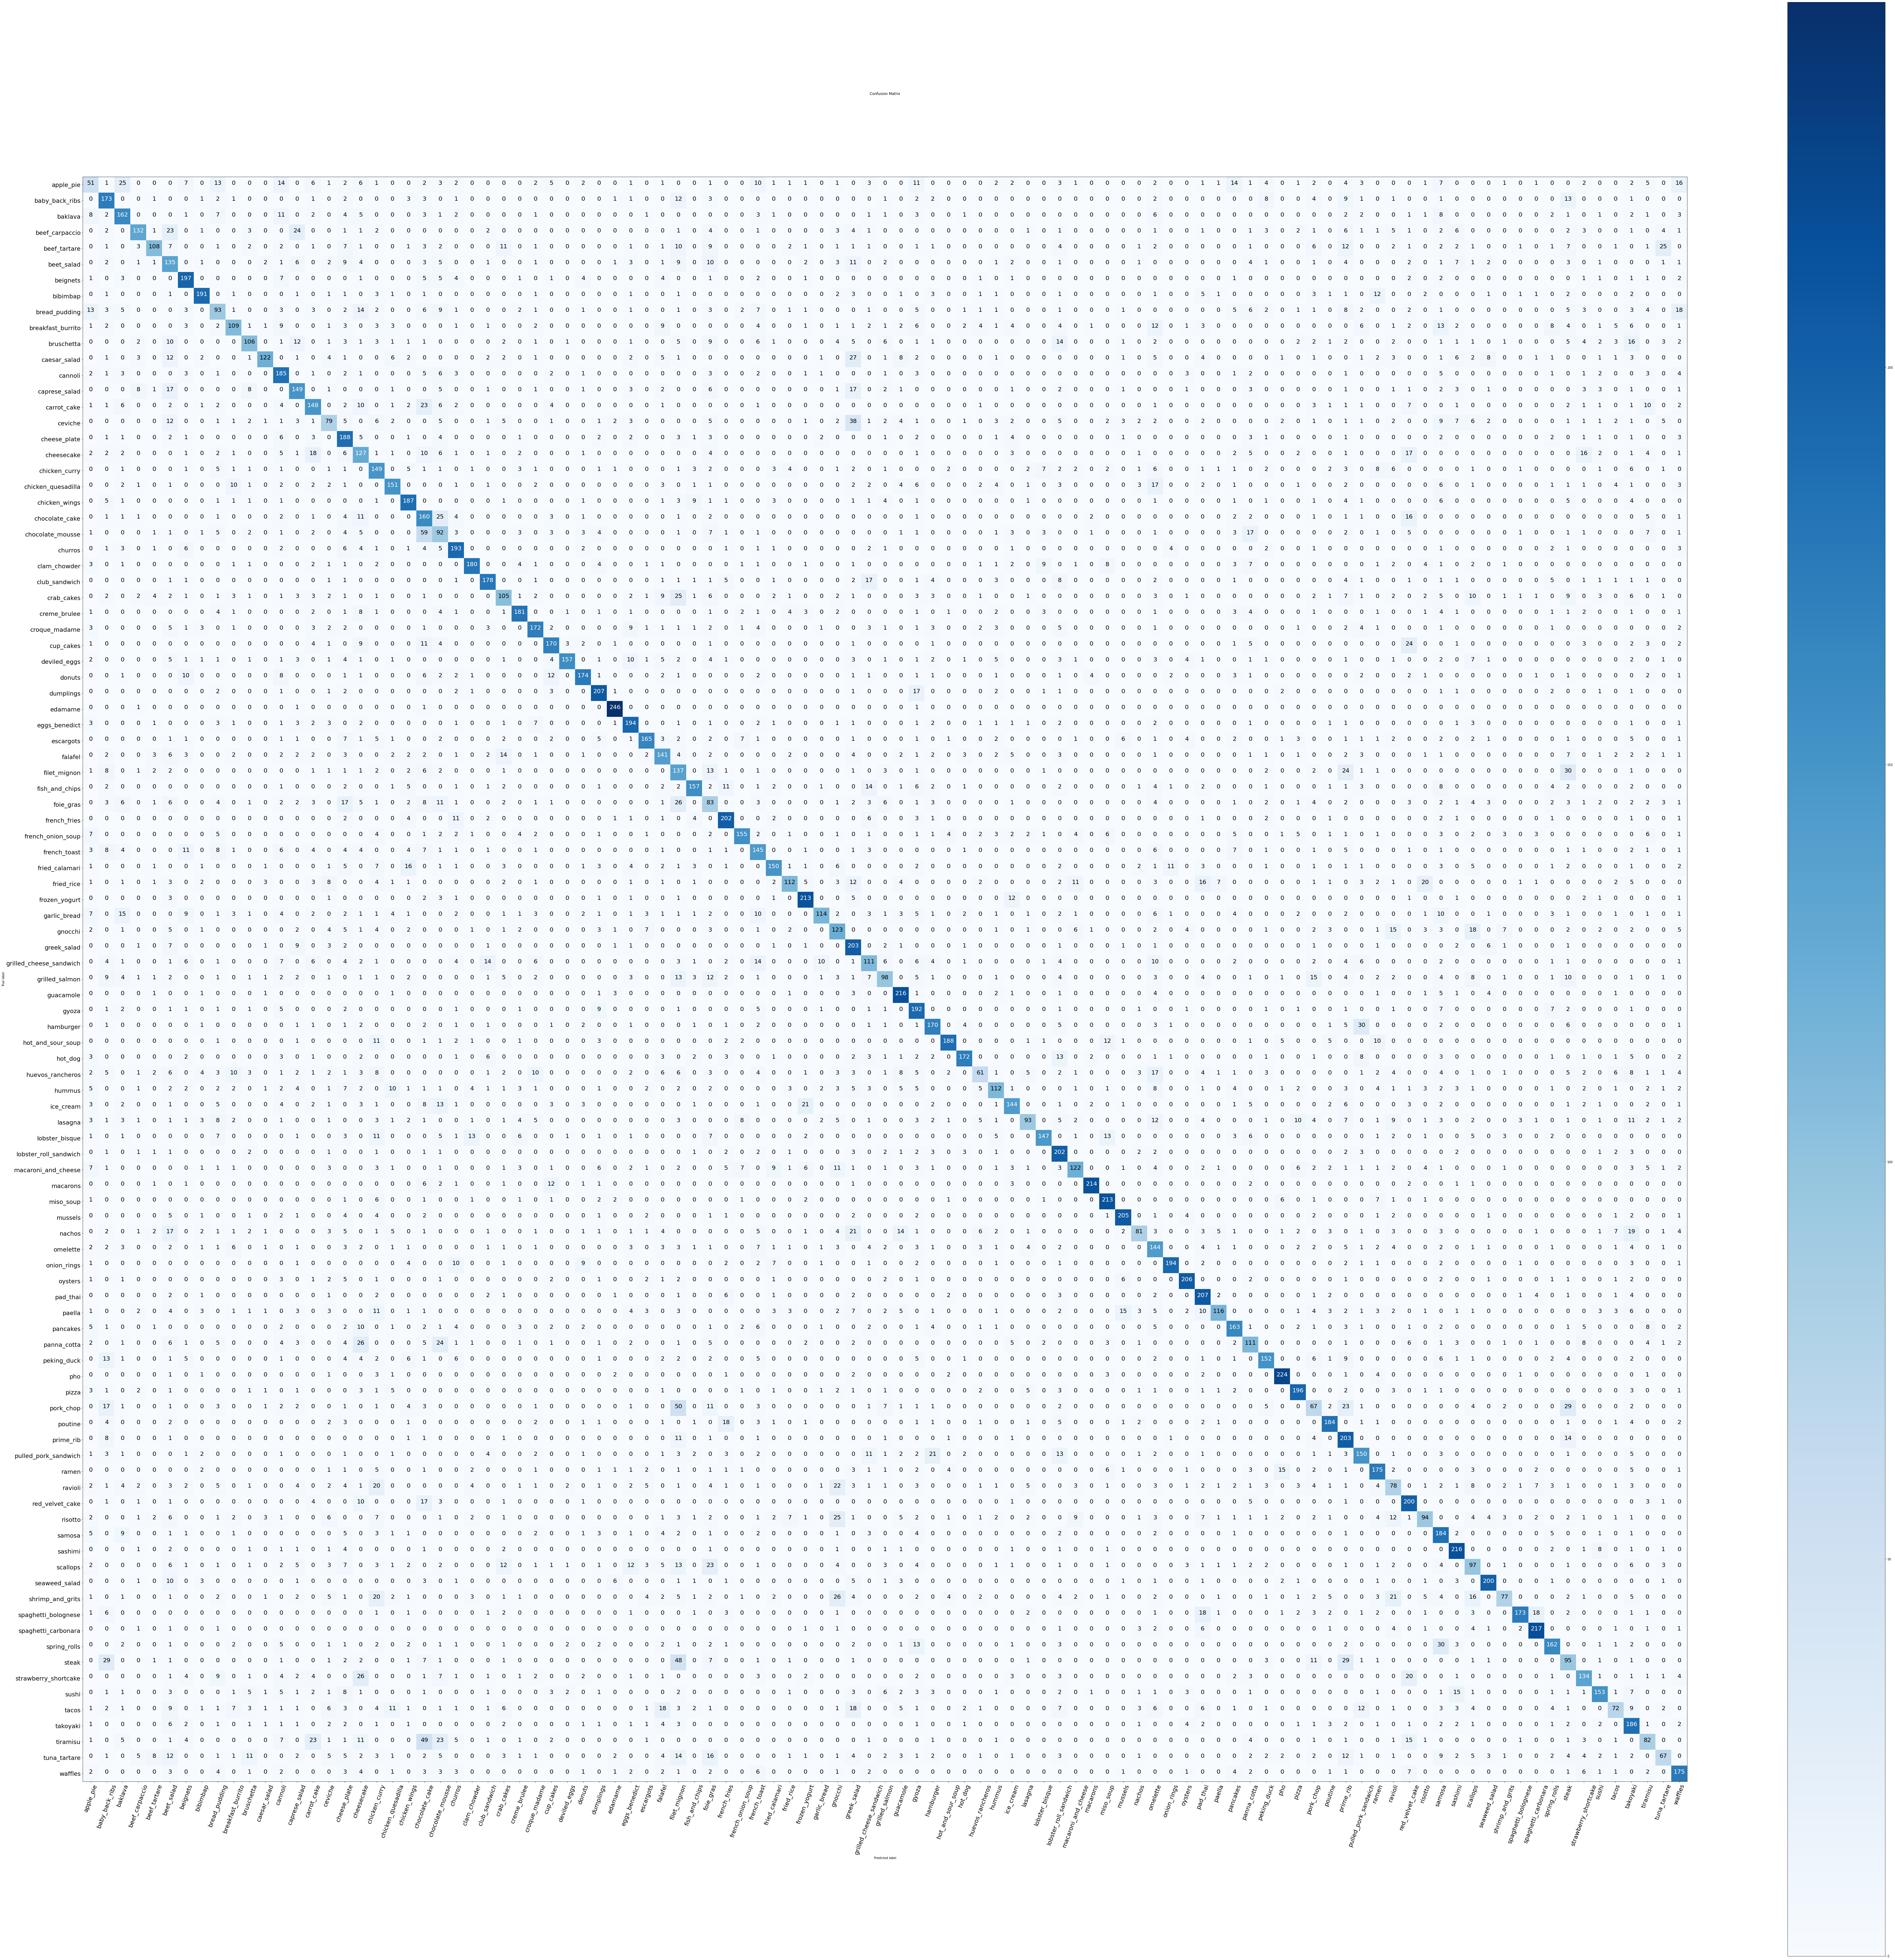

In [ ]:
make_confusion_matrix(y_labels,pred_classes,
                      classes=test_data.class_names,
                      figsize=(120,120),text_size=20,savefig=True)

## Classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_labels,pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class by class evaluation of our model's predictions but with so mant classses, they are quite hard to understand. How about we visualize this stuff

In [ ]:
classification_report=classification_report(y_labels,pred_classes,output_dict=True)

## Let's plot all of our classes F1_scores

In [ ]:
f1_scores={}
class_names=test_data.class_names
for k,v in classification_report.items():
  if k=='accuracy':
    break
  else:
    #add class names and f1_scores to new dict
    f1_scores[class_names[int(k)]]=v['f1-score']

In [ ]:
f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
#turn f1-score to dataframe
import pandas as pd
f1_scores_df=pd.DataFrame({'class_names':list(f1_scores.keys()),
                           'f1-score':list(f1_scores.values())}).sort_values('f1-score',ascending=False)

In [ ]:
f1_scores_df

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

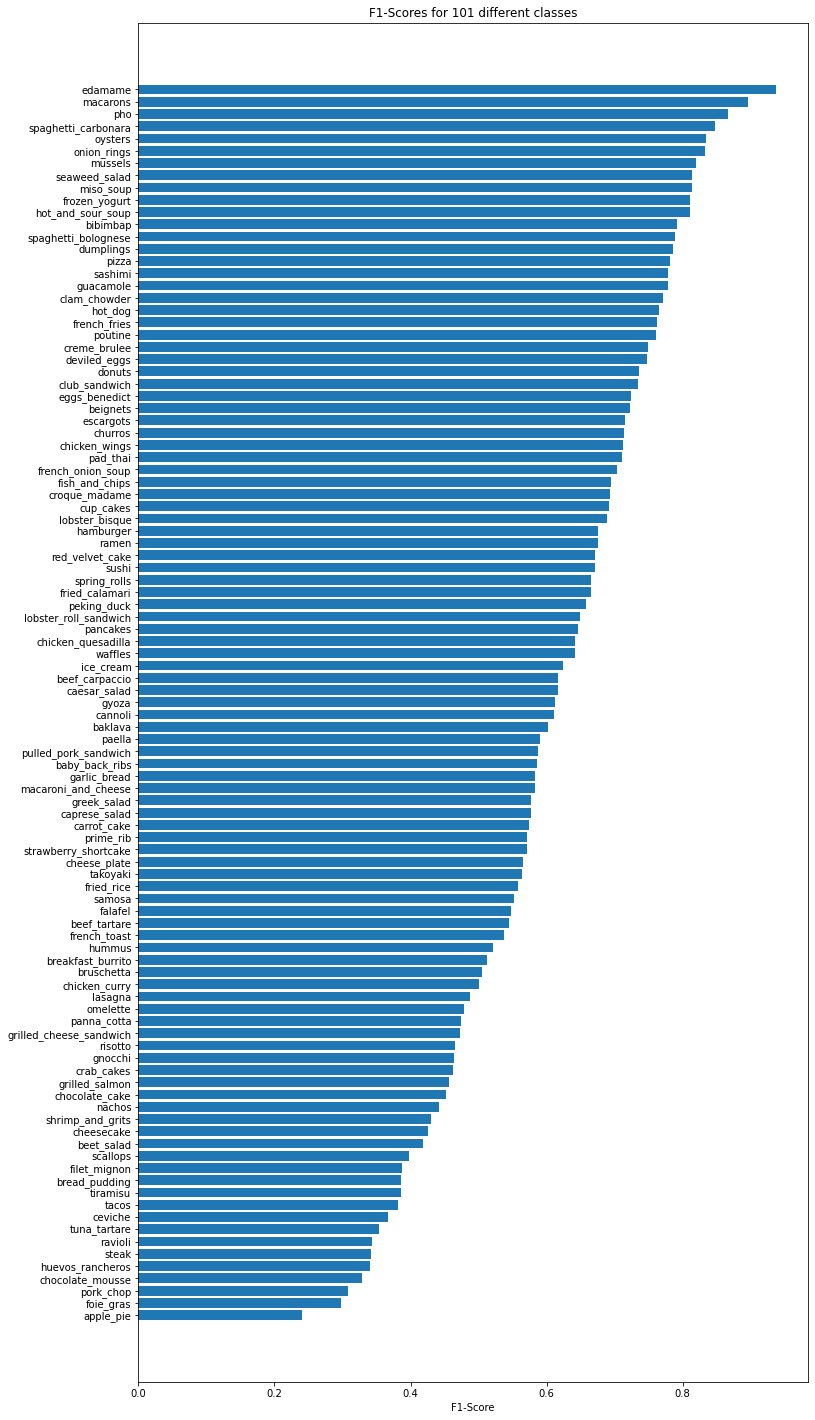

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(12,25))
#creates bar chart
scores=ax.barh(range(len(f1_scores_df)),f1_scores_df['f1-score'].values)
#sets no of ticks
ax.set_yticks(range(len(f1_scores_df)))
#sets labels for ticks
a=ax.set_yticklabels(f1_scores_df['class_names'])

ax.set_xlabel('F1-Score')
ax.set_title('F1-Scores for 101 different classes')
#invert the ais
ax.invert_yaxis()

## Viusalizing predictions on custom images

Now, this is a real test, how does our model go on food imges not even in our test Dataset

We'll need a function to load and preprocess our images.

* Read in a target filepath using tf.io.read_file()
* turn the image into a tensor using tf.io.decode_image()
* resize the image using tf.image.resize()
* scale the images to geta ll of the pixel valeus between o &1 (if necessary)

In [ ]:
def load_and_prep_image(filename,img_shape=224,scale=True):
  '''Read in a n iamge from filename and turns it intoa tensor and reshapes into
  specified shape(img_shape, img_shape, color_channels=3)'''

  #read image
  img=tf.io.read_file(filename)
  
  #decode image
  img=tf.io.decode_image(img,channels=3)

  #resize the image
  img=tf.image.resize(img,size=[img_shape,img_shape])
  if scale:
    #rescale the image
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target iamges, let's now write some code to visualize images, their target labels and our model's predictions

Specifically, we'll write some code to:

1. Load a few random iamges from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability

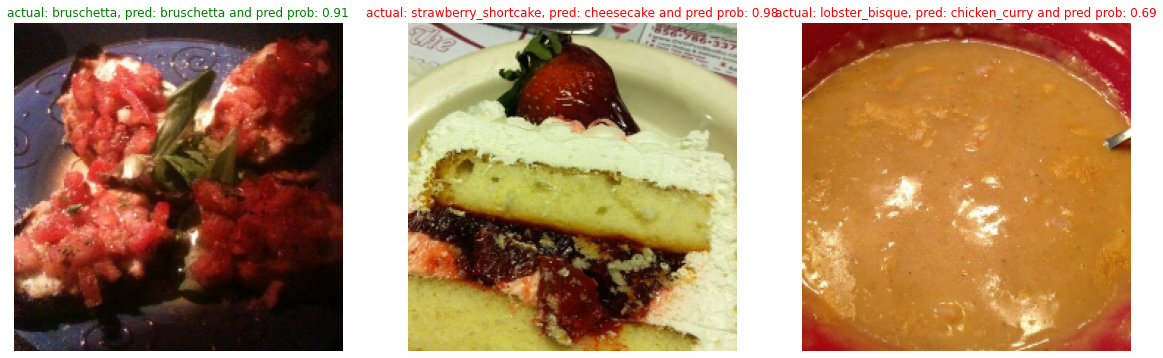

In [ ]:
import os
import random
plt.figure(figsize=(20,25))
for i in range(3):
  #choose random images from random classes
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+'/'+class_name))
  filepath=test_dir+'/'+class_name+'/'+filename
  
  img=load_and_prep_image(filepath,scale=False)
  #not expanding dims will create and error because we trained our model on
  #batched dataset
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]

  #plot image

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)  #matplotlib needs normalized images
  if class_name==pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f'actual: {class_name}, pred: {pred_class} and pred prob: {pred_prob.max():.2f}',c=title_color)
  plt.axis(False)

## Finding the most wrong predictions

To find out where our model is most wring,  let's write some code to find out the followwing:
1. Get all of the image file path in the test dataset using list_files() method
2. Create a pandas Dataframe of the iamge filepaths, ground truth labels, predicited classses(from our model), max predicition probabilities, prediction classnames,groundtruth class names
3. Use our DataFrame to find all the wrong predictions (where ground truth label doesn;t match the prediction)
4. Sort the dataframe based on wrong predictions (have the highest prediction probability prediction at the top).
5. Visualize the images with t he highest prediction probabilities but have the wrong predicition.

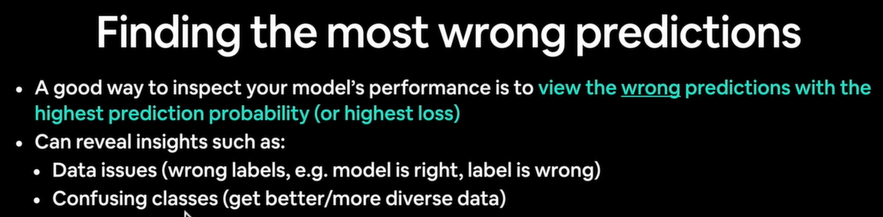

In [ ]:
filepaths=[]
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle=False):
  filepaths.append(filepath.numpy())

In [ ]:
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# create dataframe
pred_df=pd.DataFrame({'img_path':filepaths,
                      'y_true':y_labels,
                      'y_pred':pred_classes,
                      'pred_conf':pred_probs.max(axis=1),
                      'y_true_classnames':[class_names[i] for i in y_labels],
                      'y_pred_classnames': [class_names[i] for i in pred_classes]})

In [ ]:
pred_df.head(5)

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classnames     y_pred_classnames  
0   0.847419         apple_pie                 gyoza  
1   0.964017         apple_pie             apple_pie  
2   0.959259         apple_pie             apple_pie  
3   0.658607         apple_pie  pulled_pork_sandwich  
4   0.367900         apple_pie             prime_rib

In [ ]:
# find the wrong predictions in our model
pred_df['pred_correct']= pred_df['y_true'] == pred_df['y_pred']
 

In [ ]:
pred_df.head(5)

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classnames     y_pred_classnames  pred_correct  
0   0.847419         apple_pie                 gyoza         False  
1   0.964017         apple_pie             apple_pie          True  
2   0.959259         apple_pie             apple_pie          True  
3   0.658607         apple_pie  pulled_pork_sandwich         False  
4   0.367900         apple_pie             prime_rib         False

In [ ]:
# sort our dataframe to have most wrong predictions at the top

top_100_wrong=pred_df[pred_df['pred_correct']==False].sort_values(by='pred_conf',ascending=False).head(100)


In [ ]:
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf      y_true_classnames      y_pred_classnames  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

In [ ]:
top_100_wrong.iloc[0]

img_path             b'/content/101_food_classes_10_percent/test/sc...
y_true                                                              87
y_pred                                                              29
pred_conf                                                     0.999997
y_true_classnames                                             scallops
y_pred_classnames                                            cup_cakes
pred_correct                                                     False
Name: 21810, dtype: object

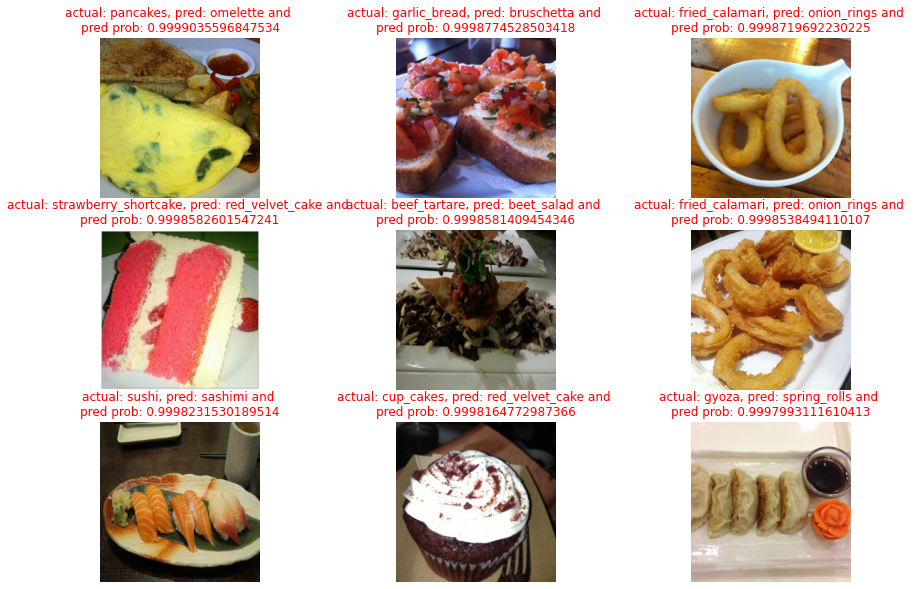

In [ ]:
plt.figure(figsize=(15,10))
start_index=10
for i in range(9):
  #get rows
  img_path,a,b,pred_prob,class_name,pred_class,pred_correct=top_100_wrong.iloc[start_index+i]
  
  img=load_and_prep_image(img_path,scale=False)
  #plot image
  plt.subplot(3,3,i+1)
  plt.imshow(img/255.)  #matplotlib needs normalized images
  if pred_correct:
    title_color='g'
  else:
    title_color='r'
  plt.title(f'actual: {class_name}, pred: {pred_class} and \npred prob: {pred_prob.max()}',c=title_color)
  plt.axis(False)

Checking the most wrong predictions is necessary because it allows you to check for wrong labels and how model is getting confused. you might mix two classes together because they are closely related

# Test out the model on our own custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-08-03 08:47:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 108.177.11.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-08-03 08:47:49 (122 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data('custom_food_images.zip')

In [ ]:
custom_food_images=['custom_food_images/'+ img_path for img_path in os.listdir('custom_food_images')]

In [ ]:
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg']

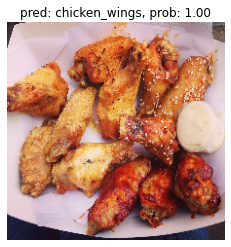

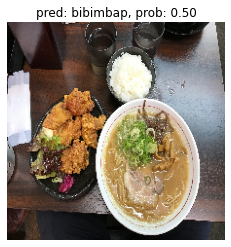

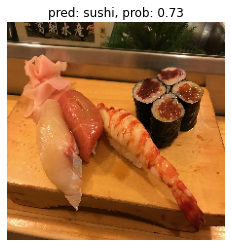

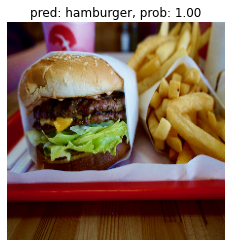

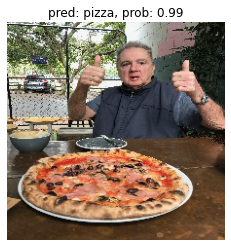

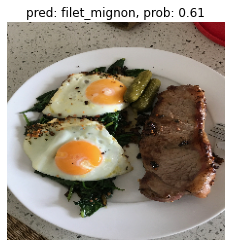

In [ ]:
# make predictions on and plot custom food images

for img in custom_food_images:
  img=load_and_prep_image(img,scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'pred: {pred_class}, prob: {pred_prob.max():.2f}')
  plt.axis(False)

(-0.5, 223.5, 223.5, -0.5)

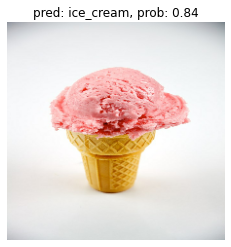

In [ ]:
  img=load_and_prep_image('/content/Strawberry_ice_cream_cone_(5076899310).jpg',scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'pred: {pred_class}, prob: {pred_prob.max():.2f}')
  plt.axis(False)